In [38]:
import pylab
import numpy
from random import random, randint

In [58]:
def eval(graph,values,index=-1):
  if index == -1:
    index = find_output_node(graph)
  node = graph[index]
  if lib[node["lib_id"]] == "value":
    return values[node["arg_index"]]
  else:
    args = []
    for argument in node["input"]:
      arg = eval(graph,values,argument)
      args.append(arg)
    return lib[node["lib_id"]](args)

def find_output_node(graph):
    referenced = []
    for node in graph:
      referenced += node["input"]
    for n, node in enumerate(graph):
      if n not in referenced:
        return n
    
def number_of_arguments(graph):
    n_arg = 0
    for n, node in enumerate(graph):
        if lib[node["lib_id"]] == "value":
            n_arg += 1
    return n_arg

In [ ]:
lib = ["value",lambda a:a[0]+a[1],lambda a:a[0]-a[1],lambda a:a[0]*a[1],lambda a:a[0]/a[1]]

#a*(b+c)
g1 = [{"lib_id":0,"input":[],"arg_index":0},{"lib_id":0,"input":[],"arg_index":1},{"lib_id":0,"input":[],"arg_index":2},{"lib_id":1,"input":[1,2]},{"lib_id":3,"input":[0,3]}]
#(a+b)**2
g2 = [{"lib_id":0,"input":[],"arg_index":0},{"lib_id":0,"input":[],"arg_index":1},{"lib_id":3,"input":[3,4]},{"lib_id":1,"input":[0,1]},{"lib_id":1,"input":[0,1]}]

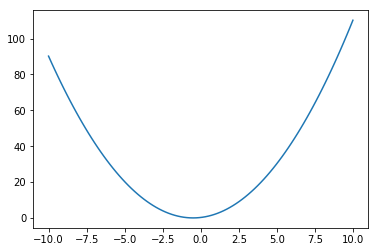

In [64]:
pylab.close()
x = numpy.linspace(-10,10,100)
values = [random() for n in range(number_of_arguments(g2))]
value_matrix = [[(xe if v == 0 else value) for v, value in enumerate(values)] for xe in x]
y = numpy.array([ eval(g2,value_matrix[i]) for i in range(len(value_matrix)) ])
pylab.plot(x,y)

pylab.show()